# RFM Analysis and Customer Segmentation

### Data Loading

In [18]:
import pandas as pd
import numpy as np

data = pd.read_csv("Sales.csv")

In [19]:
data.head()

,order_id,order_date,User name,products,Total_Items,Total cost,Payment method,City,Store type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,21/01/2022 06:27,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000008,05/04/2021 06:32,Kimberly Morgan,['Insect Repellent'],4,55.25,Mobile Payment,Los Angeles,Warehouse Club,False,Homemaker,Fall,NaN
2,1000000037,31/05/2020 05:35,Annette Robinson,['Garden Hose'],4,25.76,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Fall,BOGO (Buy One Get One)
3,1000000047,06/02/2023 01:31,Roberto Franklin,"['Pasta', 'Olive Oil']",7,76.09,Mobile Payment,Los Angeles,Convenience Store,True,Retiree,Summer,NaN
4,1000000054,02/03/2023 19:56,Rebecca Gilmore,"['Olive Oil', 'Feminine Hygiene Products', 'To...",8,46.79,Debit Card,Los Angeles,Specialty Store,False,Retiree,Winter,NaN


### Data Cleaning

In [8]:
data = data.dropna(subset=['User name'])

data = data[data['City'] == 'Los Angeles']

data['order_date'] = pd.to_datetime(data['order_date'])

C:\Users\hp\AppData\Local\Temp\ipykernel_14032\3382995872.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['order_date'] = pd.to_datetime(data['order_date'])


In [9]:
duplicates = data[data.duplicated()]

duplicates

,order_id,order_date,User name,products,Total_Items,Total cost,Payment method,City,Store type,Discount_Applied,Customer_Category,Season,Promotion


In [10]:
data = data.drop_duplicates()

In [11]:
data['User name'].nunique()

70926

### RFM Feature Engineering

In [ ]:
max_date = data['order_date'].max()

rfm = data.groupby('User name').agg({
    'order_date': lambda x: (max_date - x.max()).days,  # Recency
    'order_id': 'nunique',                              # Frequency
    'Total cost': 'sum'                                 # Monetary
})

rfm.rename(columns={
    'order_date': 'Recency',
    'order_id': 'Frequency',
    'Total cost': 'Monetary'
}, inplace=True)

rfm = rfm[['Recency', 'Frequency', 'Monetary']]
rfm.head()

,Recency,Frequency,Monetary
User name,,,
Aaron Adams,33,2,108.50
Aaron Adkins,1237,1,76.41
Aaron Alexander,247,1,14.78
Aaron Allen,475,4,257.62
Aaron Anderson,487,1,88.08


### Standardize the RFM features 


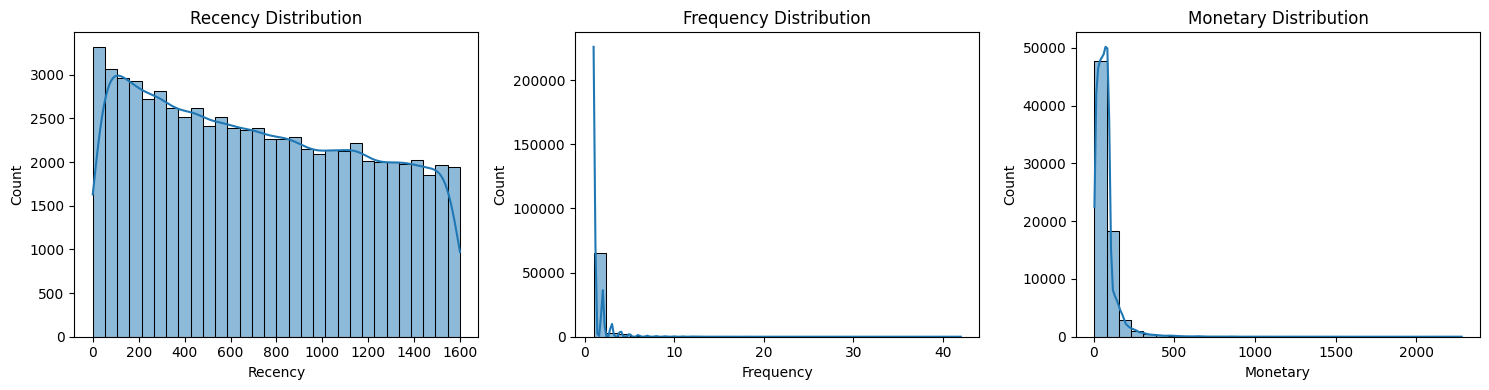

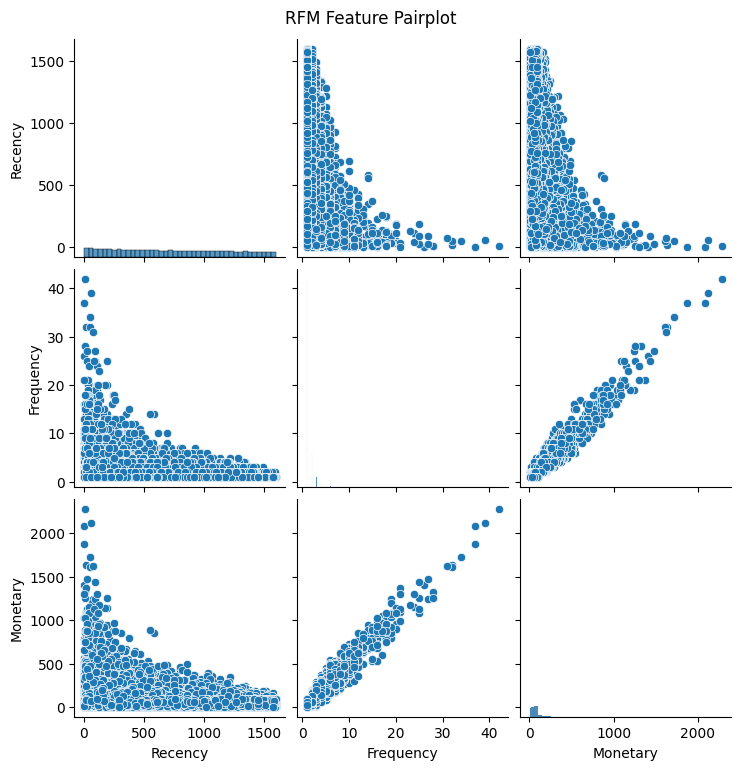

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm), columns=rfm.columns, index=rfm.index)

plt.figure(figsize=(15, 4))
for i, col in enumerate(rfm.columns):
    plt.subplot(1, 3, i+1)
    sns.histplot(rfm[col], kde=True, bins=30)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

sns.pairplot(rfm)
plt.suptitle('RFM Feature Pairplot', y=1.02)
plt.show()

### K-Means Clustering with Elbow Method and PCA Visualization

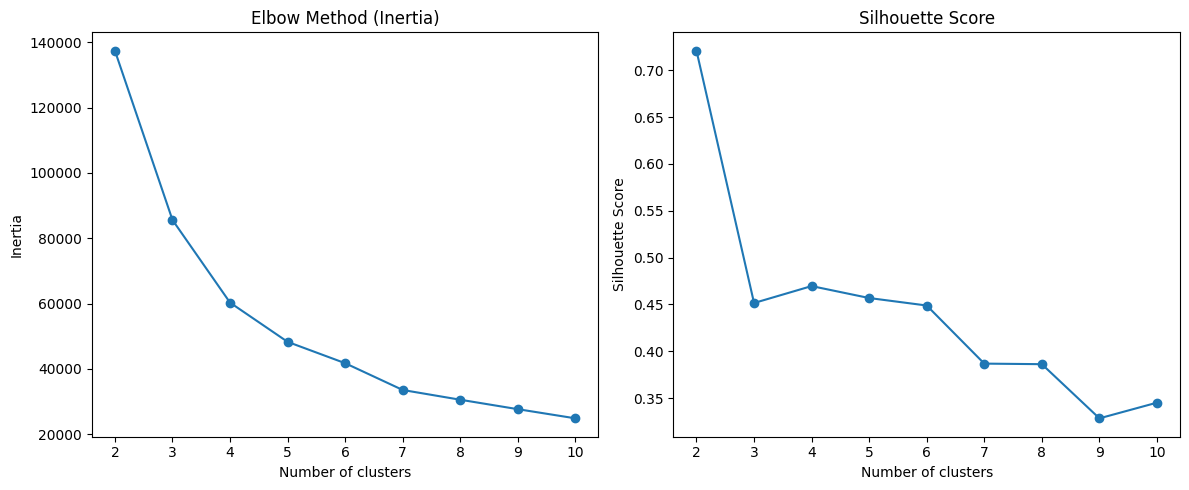

In [14]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

rfm_sample = rfm_scaled.sample(n=1000, random_state=42) if len(rfm_scaled) > 1000 else rfm_scaled

inertia = []
silhouette = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_sample, kmeans.predict(rfm_sample)))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.subplot(1,2,2)
plt.plot(k_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

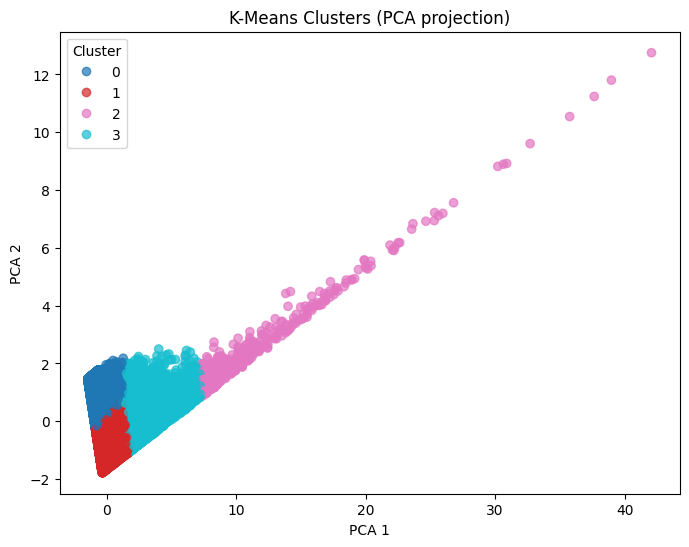

In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(rfm_scaled)
rfm['KMeans_Cluster'] = kmeans_labels

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
plt.figure(figsize=(8,6))
scatter = plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=kmeans_labels, cmap='tab10', alpha=0.7)
plt.title('K-Means Clusters (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()


### Cluster Centroids and Interpretation

In [ ]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=rfm.columns[:3])
print('K-Means Cluster Centroids (original RFM scale):')
display(centroids_df)

for i, row in centroids_df.iterrows():
    print(f"Cluster {i}: Recency={row['Recency']:.1f}, Frequency={row['Frequency']:.1f}, Monetary={row['Monetary']:.1f}")



K-Means Cluster Centroids (original RFM scale):


,Recency,Frequency,Monetary
0,1179.582764,1.080399,56.040773
1,381.817623,1.229784,63.234443
2,127.525381,12.568528,664.594746
3,324.449127,3.974032,220.118516


Cluster 0: Recency=1179.6, Frequency=1.1, Monetary=56.0
Cluster 1: Recency=381.8, Frequency=1.2, Monetary=63.2
Cluster 2: Recency=127.5, Frequency=12.6, Monetary=664.6
Cluster 3: Recency=324.4, Frequency=4.0, Monetary=220.1
